# Module 3 — Explainability (PyTorch, MNIST)

This notebook mirrors a TensorFlow-based explainability workflow using **PyTorch** and **MNIST**.

Contents:
- Train a CNN
- Explanations: Saliency, Integrated Gradients, SmoothGrad, Occlusion, Grad-CAM
- Superpixels with signed Δlogit heatmaps
- Deletion/Insertion curves, attribution quality tables, bar charts


In [1]:

import os, random, numpy as np, torch
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

def set_seed(s=945):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# Prefer MPS on Mac, then CUDA, else CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Device:", device)


Device: mps


In [2]:

class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        self.fc1 = nn.Linear(64*14*14,128)
        self.fc2 = nn.Linear(128,num_classes)
        self.dropout = nn.Dropout(0.25)
        self.last_conv = self.conv3
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

transform = transforms.ToTensor()
train_ds = datasets.MNIST("./data",train=True,download=True,transform=transform)
test_ds = datasets.MNIST("./data",train=False,download=True,transform=transform)
train_loader = DataLoader(train_ds,batch_size=128,shuffle=True)
test_loader = DataLoader(test_ds,batch_size=128)
model = SmallCNN().to(device)


In [3]:

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch():
    model.train(); tot,correct,loss_sum=0,0,0
    for x,y in train_loader:
        x,y=x.to(device),y.to(device)
        opt.zero_grad()
        out=model(x)
        loss=F.cross_entropy(out,y)
        loss.backward(); opt.step()
        loss_sum+=loss.item()*x.size(0)
        pred=out.argmax(1); correct+=(pred==y).sum().item(); tot+=x.size(0)
    return loss_sum/tot, correct/tot

@torch.no_grad()
def evaluate():
    model.eval(); tot,correct,loss_sum=0,0,0
    for x,y in test_loader:
        x,y=x.to(device),y.to(device)
        out=model(x); loss=F.cross_entropy(out,y)
        loss_sum+=loss.item()*x.size(0)
        pred=out.argmax(1); correct+=(pred==y).sum().item(); tot+=x.size(0)
    return loss_sum/tot, correct/tot

for ep in range(2):
    tr_loss,tr_acc=train_one_epoch()
    te_loss,te_acc=evaluate()
    print(ep+1,tr_loss,tr_acc,te_loss,te_acc)


1 0.21692117224931717 0.9342166666666667 0.04770216502863914 0.9845
2 0.05548140229582787 0.9826 0.03693052713153884 0.9873


In [4]:

def saliency_vanilla(model,x,target):
    x=x.clone().detach().requires_grad_(True)
    out=model(x); logit=out[:,target].sum()
    model.zero_grad(set_to_none=True); logit.backward()
    grad=x.grad.detach(); return grad.abs().max(dim=1)[0]

def integrated_gradients(model,x,target,steps=32,baseline=None):
    if baseline is None: baseline=torch.zeros_like(x)
    alphas=torch.linspace(0,1,steps,device=x.device).view(-1,1,1,1)
    x_interp=baseline+alphas*(x-baseline); x_interp.requires_grad_(True)
    out=model(x_interp); logit=out[:,target].sum()
    model.zero_grad(set_to_none=True); logit.backward()
    grads=x_interp.grad.mean(0,keepdim=True)
    return ((x-baseline)*grads).abs().max(dim=1)[0]

def smoothgrad(model,x,target,n=16,sigma=0.2):
    sals=[]
    for _ in range(n):
        xn=(x+torch.randn_like(x)*sigma).clamp(0,1)
        sals.append(saliency_vanilla(model,xn,target))
    return torch.stack(sals).mean(0)

@torch.no_grad()
def occlusion(model,x,target,patch=5,stride=2,val=0.0):
    base=model(x)[:,target].item(); H,W=x.shape[2:]
    heat=torch.zeros((H,W))
    for i in range(0,H-patch+1,stride):
        for j in range(0,W-patch+1,stride):
            x_occ=x.clone(); x_occ[:,:,i:i+patch,j:j+patch]=val
            logit=model(x_occ)[:,target].item()
            drop=base-logit; heat[i:i+patch,j:j+patch]+=drop
    heat=heat-heat.min()
    if heat.max()>0: heat/=heat.max()
    return heat.unsqueeze(0)

class GradCAM:
    def __init__(self,model,layer):
        self.model=model; self.layer=layer
        self.fmap=None; self.grad=None
        self.hf=layer.register_forward_hook(self.fhook)
        self.hb=layer.register_full_backward_hook(self.bhook)
    def fhook(self,m,i,o): self.fmap=o.detach()
    def bhook(self,m,gi,go): self.grad=go[0].detach()
    def __call__(self,x,target):
        x=x.clone().detach().requires_grad_(True)
        out=self.model(x); logit=out[:,target].sum()
        self.model.zero_grad(set_to_none=True); logit.backward()
        w=self.grad.mean(dim=(2,3),keepdim=True)
        cam=(w*self.fmap).sum(1,keepdim=True); cam=F.relu(cam)
        cam=cam-cam.min(); 
        if cam.max()>0: cam/=cam.max()
        return cam
    def close(self): self.hf.remove(); self.hb.remove()


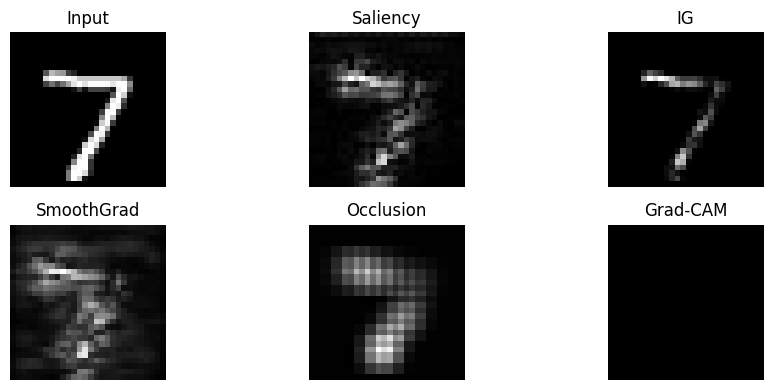

In [5]:

x,y=next(iter(test_loader))
x,y=x.to(device),y.to(device)
i=0; xi=x[i:i+1]; yi=int(y[i]); pred=int(model(xi).argmax(1))

sal=saliency_vanilla(model,xi,pred)
ig=integrated_gradients(model,xi,pred)
sg=smoothgrad(model,xi,pred)
occ=occlusion(model,xi,pred)[0]

gcam=GradCAM(model,model.last_conv)
cam=gcam(xi,pred)[0,0]; gcam.close()

plt.figure(figsize=(10,4))
for j,(m,title) in enumerate([(xi.squeeze().cpu(),"Input"),
                              (sal.squeeze().cpu(),"Saliency"),
                              (ig.squeeze().cpu(),"IG"),
                              (sg.squeeze().cpu(),"SmoothGrad"),
                              (occ.squeeze().cpu(),"Occlusion"),
                              (cam.squeeze().cpu(),"Grad-CAM")]):
    plt.subplot(2,3,j+1); plt.imshow(m,cmap='gray'); plt.title(title); plt.axis('off')
plt.tight_layout(); plt.show()



## 7) LIME‑style Superpixel Explanations (from scratch)

We mimic **LIME** (Local Interpretable Model‑agnostic Explanations) for a *single image*:
1. Segment the image into **superpixels** (SLIC or a grid fallback).
2. Create **binary masks** that keep/hide different superpixel subsets (local perturbations).
3. Query the model on the perturbed images to get the **target class probability**.
4. Fit a **weighted linear model** over the superpixel indicators to locally approximate the model.
5. Highlight the **top positive** superpixels (those that *increase* the target class score).

> Interpreting the plot: highlighted regions are the parts of the image the model most relied on for the predicted class.


In [6]:

# --- LIME utilities (SLIC is already imported earlier if available) ---
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def build_segments_for_lime(x_img, n_segments=50):
    """Return superpixel labels [H,W] using SLIC if available, else grid."""
    H = x_img.shape[-2]; W = x_img.shape[-1]
    try:
        from skimage.segmentation import slic
        img = x_img.detach().cpu().numpy().squeeze()
        rgb = np.stack([img,img,img], axis=-1)
        segs = slic(rgb, n_segments=n_segments, compactness=8.0, sigma=0.5, start_label=0)
        return segs
    except Exception:
        # grid fallback
        gh, gw = 7, 7
        segs = np.zeros((H,W), dtype=np.int32)
        hs, ws = H//gh, W//gw
        lbl = 0
        for i in range(gh):
            for j in range(gw):
                r0,r1 = i*hs, (i+1)*hs if i<gh-1 else H
                c0,c1 = j*ws, (j+1)*ws if j<gw-1 else W
                segs[r0:r1, c0:c1] = lbl; lbl += 1
        return segs

@torch.no_grad()
def model_prob_for_target(model, x, target):
    model.eval()
    logits = model(x); prob = F.softmax(logits, dim=1)[0, target].item()
    return prob

def lime_explain(model, x, target, segments, num_samples=500, hide_val=0.0, kernel_width=0.25, l2=1e-3):
    """Return weights per superpixel via a LIME-like weighted ridge regression.
    - x: [1,1,H,W] in [0,1]
    - target: int
    - segments: [H,W] labels
    """
    seg_ids = np.unique(segments); m = len(seg_ids)
    # Binary masks Z \in {0,1}^{num_samples x m}: 1=keep, 0=hide
    Z = np.random.binomial(1, 0.5, size=(num_samples, m)).astype(np.float32)
    # Ensure the full image (all ones) is included
    Z[0,:] = 1.0

    # Build perturbed images and query model
    X_probs = np.zeros((num_samples,), dtype=np.float32)
    base = x.clone()
    for i in range(num_samples):
        z = Z[i]
        x_p = base.clone()
        # hide selected superpixels
        hide_mask = np.zeros_like(segments, dtype=bool)
        for idx, sid in enumerate(seg_ids):
            if z[idx] == 0:
                hide_mask |= (segments == sid)
        x_p[:, :, hide_mask] = hide_val
        X_probs[i] = model_prob_for_target(model, x_p, target)

    # Distances in binary space to the full mask (all ones)
    d = np.sqrt(((Z - 1.0) ** 2).sum(axis=1)) / max(1, m)
    W = np.exp(- (d ** 2) / (kernel_width ** 2))  # kernel weights

    # Weighted ridge regression: (Z^T W Z + l2 I) w = Z^T W y
    ZW = Z * W[:, None]
    A = Z.T @ ZW + l2 * np.eye(m, dtype=np.float32)
    b = Z.T @ (W * X_probs)
    w = np.linalg.solve(A, b)  # [m]

    # Map weights back to image
    weight_map = np.zeros_like(segments, dtype=np.float32)
    for idx, sid in enumerate(seg_ids):
        weight_map[segments == sid] = w[idx]

    return w, weight_map, seg_ids

def plot_lime_overlay(x, segments, weight_map, top_k=8, title="LIME-style Explanation (positive regions)"):
    # pick top positive superpixels (by mean weight)
    seg_ids = np.unique(segments)
    seg_scores = []
    for sid in seg_ids:
        seg_scores.append((sid, float(weight_map[segments==sid].mean())))
    seg_scores = sorted(seg_scores, key=lambda kv: kv[1], reverse=True)
    keep_ids = [sid for sid,sc in seg_scores if sc>0][:top_k]

    H,W = segments.shape
    mask = np.zeros((H,W), dtype=np.float32)
    for sid in keep_ids:
        mask[segments==sid] = 1.0

    plt.figure()
    plt.imshow(x.detach().cpu().squeeze().numpy(), cmap='gray')
    plt.imshow(mask, alpha=0.5)
    try:
        from skimage.segmentation import mark_boundaries
        overlay = mark_boundaries(np.stack([x.detach().cpu().squeeze().numpy()]*3, axis=-1), segments, mode='thick')
        plt.imshow(overlay, alpha=0.8)
    except Exception:
        for r in range(1,H):
            if (segments[r]!=segments[r-1]).any(): plt.axhline(r-0.5, linewidth=0.5)
        for c in range(1,W):
            if (segments[:,c]!=segments[:,c-1]).any(): plt.axvline(c-0.5, linewidth=0.5)
    plt.axis('off'); plt.title(title)
    plt.show()


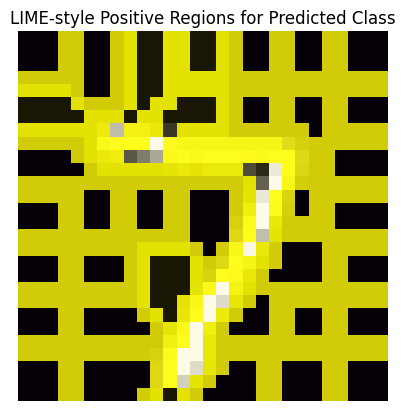

,SegmentID,Weight (local linear model)
27,27,0.232506
15,15,0.219877
8,8,0.172595
2,2,0.118448
13,13,0.071650
7,7,0.060910
25,25,0.050247
3,3,0.046793
31,31,0.042442
19,19,0.040877


In [7]:

# --- Run LIME on the demo image (xi, pred) ---
segments = build_segments_for_lime(xi, n_segments=50)
w, weight_map, seg_ids = lime_explain(model, xi, pred, segments, num_samples=500, hide_val=0.0, kernel_width=0.25, l2=1e-3)
plot_lime_overlay(xi, segments, weight_map, top_k=8, title="LIME-style Positive Regions for Predicted Class")

# Show a small table of top segments by mean weight
import pandas as pd
rows = []
for sid in np.unique(segments):
    rows.append([int(sid), float(weight_map[segments==sid].mean())])
df_lime = pd.DataFrame(rows, columns=["SegmentID","Weight (local linear model)"]).sort_values("Weight (local linear model)", ascending=False)
df_lime.head(12)



**How to read this LIME-style plot**  
- Highlighted superpixels are those with the **largest positive weights** in a simple local linear model that approximates the CNN around this image.  
- These regions are where turning pixels *off* (hiding the region) most reduces the **predicted class probability** in our local fit, hence they are **supporting evidence**.  
- Non‑highlighted or negative‑weight regions would be **neutral or counter‑evidence** for this particular prediction.


In [8]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfc = RandomForestClassifier(n_estimators=100, random_state=42)

rfc.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_pred = rfc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [9]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    discretize_continuous=True,
)

In [10]:
idx = 0  # index of the sample we want to explain
exp = explainer.explain_instance(X_test[idx], rfc.predict_proba)

# Now, we can print out the top three features that are contributing to the prediction:
for i in range(3):
    print(f"{exp.as_list()[i][0]}: {exp.as_list()[i][1]:.2f}")

4.25 < petal length (cm) <= 5.10: 0.21
0.30 < petal width (cm) <= 1.30: 0.16
sepal width (cm) <= 2.80: -0.02


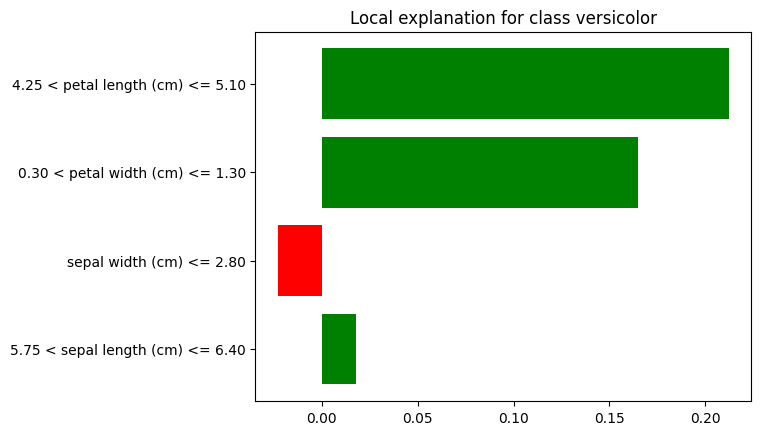

In [11]:
from lime import lime_tabular

fig = exp.as_pyplot_figure()

In [12]:
exp = explainer.explain_instance(
    data_row=X_test[1], 
    predict_fn=rfc.predict_proba
)

exp.show_in_notebook(show_table=True)

In [16]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

import shap

batch_size = 128
num_epochs = 2
device = torch.device("cpu")


class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]"
                f"\tLoss: {loss.item():.6f}"
            )


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f},"
        f" Accuracy: {correct}/{len(test_loader.dataset)}"
        f" ({100.0 * correct / len(test_loader.dataset):.0f}%)\n"
    )


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "mnist_data",
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor()]),
    ),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("mnist_data", train=False, transform=transforms.Compose([transforms.ToTensor()])),
    batch_size=batch_size,
    shuffle=True,
)

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 6.25MB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 227kB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 893kB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 423kB/s]


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319418
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.249139
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.687389
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.140760
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.798093

Test set: Average loss: 0.0049, Accuracy: 8877/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.815824
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.526274
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.420024
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.626439
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.504223

Test set: Average loss: 0.0029, Accuracy: 9298/10000 (93%)



In [17]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(test_loader))
images, _ = batch

background = images[:100]
test_images = images[100:103]

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

In [18]:
shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

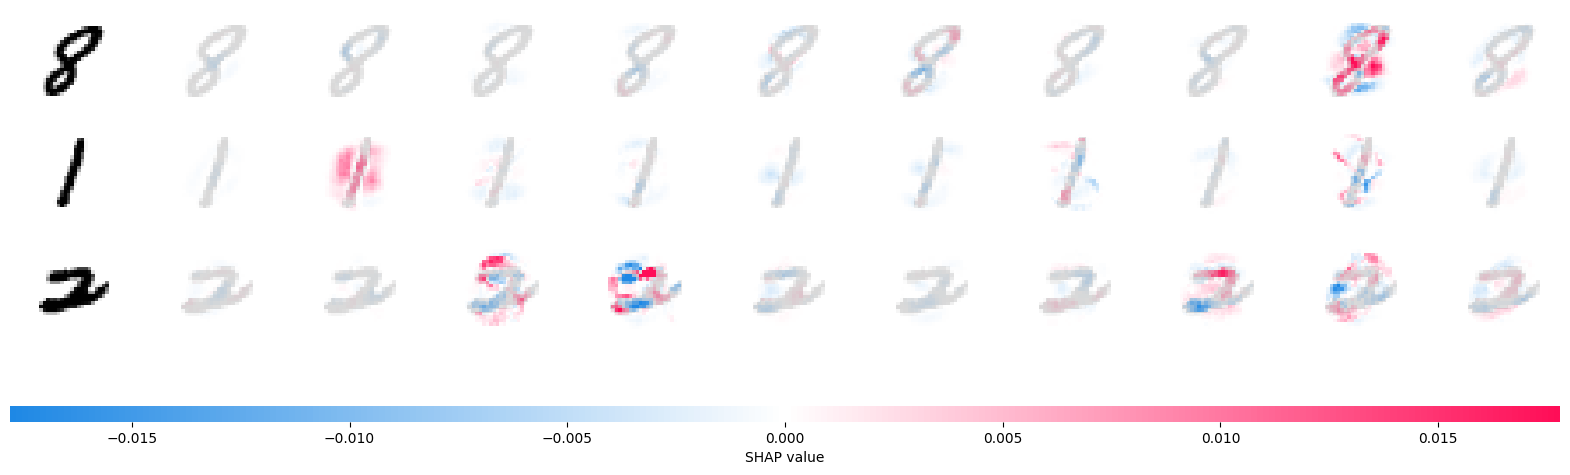

In [19]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)